# Recommendations Systems
## Assignment 2: Content Based Recommendations 

**By:**  
Group #16

<br><br>

**The goal of this assignment is to:**
- Understand the details of content based recommender systems
- Understand pros & cons comparing to other recommender system approaches
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ and up should be used.  
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).


**Grading:**
- Q1 - 10 points - Data exploration
- Q2 - 30 points - Item similarity
- Q3 - 40 points - Content based recommendation  
- Q4 - 20 points - Content based vs. matrix factorization comparison

`Total: 100`

**Prerequisites**

In [347]:
%pip install --quiet zipfile36
%pip install --quiet wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Imports**

In [348]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from wordcloud import WordCloud, STOPWORDS

# metrics - do not use these metrics directly except for validating your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# distance
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [349]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [350]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [351]:
random.seed(123)

# Question 1: 
# Data exploration 

In this exercise you will use the same dataset that we used for exercise #1:  [MovieLens 100K rating dataset](https://grouplens.org/datasets/movielens/100k/)  use Fold #2

Include additional exploration that is relevant for content based recommendation:

Explore at least 3 features.  
For example, explore the genres, titles, and you may also use [IMDB's API](https://developer.imdb.com/documentation/api-documentation/) to include additional features.  
 
Use plots and discuss your insights and possible challenges related to the dataset.


In [352]:
data_dir= '..\HW1\ml-100k\\'
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
df_actors= pd.read_csv('actorfilms.csv')

### Age of movie
We have the release date from which we can calculate the age of the movie as per the 1998 (the "youngest movie of in this dataset).

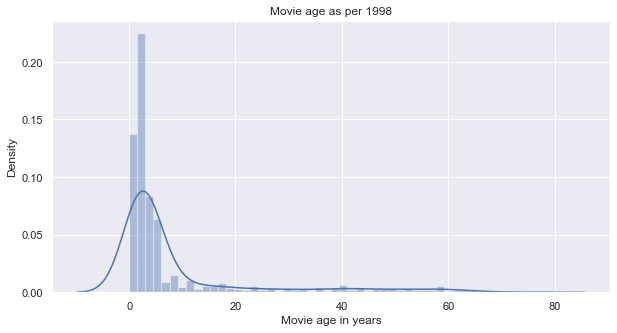

Median age of the movies is 3.0 years


In [353]:
#  detail movies by year of release
df_items['release_date'].fillna('0000', inplace=True)
df_items['ReleaseYear'] = df_items['release_date'].str[-4:].astype(int)
# get max year
max_year = df_items['ReleaseYear'].max()
df_items['MovieAge'] = max_year - df_items['ReleaseYear'].astype(int)
# plot average movie rating histogram
plt.figure(figsize=(10,5))
sns.distplot(df_items[df_items['MovieAge']< 100]['MovieAge'],kde=True, bins=50)
plt.title(f'Movie age as per {max_year}')
plt.xlabel('Movie age in years')
plt.show()
# find median movie age
median_age = df_items['MovieAge'].median()
print(f'Median age of the movies is {median_age} years')

With a median age of the movies being 3.0 years, we can probably have this feature used to help in recommending movies.
This can help us understand if a user has a taste for older movies ot they prefer to watch new releases.

### Using movie tags as features

The length of the tags dataset is 87114, giving an average of 51.8 tags per movie.
The number of unique movies in the tags dataset is 1366, which is shorter than the length of the movies dataset(1682).
The number of movies in the tags dataset which appear in the movies dataset is 1366.
The most common tag in the tags dataset is "classic" with 1209 occurences.
This tag is probably not very informative, as it is a generic tag that can be applied to many movies. We will remove it moving forward.
The number of movies in the movies dataset which are missing tags is 316.
The median count of tagmentions per movie is userId       1.0
movieId      1.0
timestamp    1.0
dtype: float64.


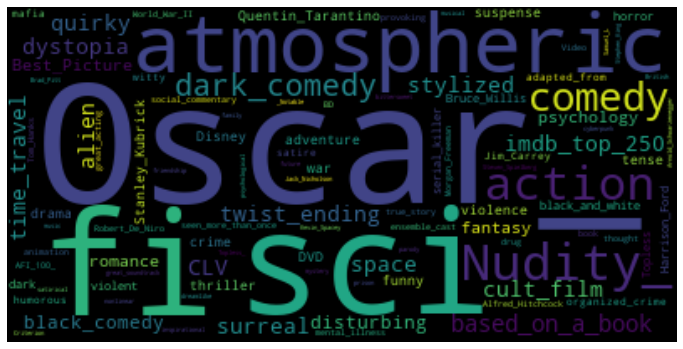

In [354]:
# the movie lens DB also has a tags dataset
df_tag= pd.read_csv('tag.csv')
df_tags=pd.read_csv('tags.csv')
# append df_tag to df_tags
df_tags = df_tags.append(df_tag)
#  drop duplicates and reset index
df_tags.drop_duplicates(inplace=True)
#  only keep the tags for movies that are in the movies dataset
df_tags = df_tags[df_tags.movieId.isin(df_items["movie id"])]
# print(df_tags[df_tags.movieId.isin(df_items["movie id"])])
print(f'The length of the tags dataset is {len(df_tags)}, giving an average of {round(len(df_tags)/len(df_items),1)} tags per movie.')
print(f'The number of unique movies in the tags dataset is {len(df_tags.movieId.unique())}, which is shorter than the length of the movies dataset({len(df_items)}).')
print(f'The number of movies in the tags dataset which appear in the movies dataset is {len(df_tags[df_tags.movieId.isin(df_items["movie id"])].value_counts("movieId"))}.')
print(f'The most common tag in the tags dataset is "{df_tags.tag.value_counts().index[0]}" with {df_tags.tag.value_counts()[0]} occurences.')
print('This tag is probably not very informative, as it is a generic tag that can be applied to many movies. We will remove it moving forward.')
# get the number of movies in df_items which are missing tags
print(f'The number of movies in the movies dataset which are missing tags is {len(df_items[~df_items["movie id"].isin(df_tags.movieId.unique())])}.')
# remove the most common tag
df_tags = df_tags[df_tags.tag != df_tags.tag.value_counts().index[0]]
print(f'The median count of tagmentions per movie is {df_tags.groupby("tag").count().median()}.')
# wordcloud of the movie tags can help us visualize the most popular tags
text = " ".join(tag.replace(" ", "_") for tag in df_tags.tag if type(tag) == str)
stopwords = set(STOPWORDS)
# Create and generate a word cloud image:
wordcloud = WordCloud(collocations=False, max_words=100).generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# df_tags.groupby("tag").count()['movieId'].sort_values(ascending=False).head(10)

The length of the tags dataset is 3683, giving an average of 2.2 tags per movie.</br>
The number of unique movies in the tags dataset is 1572, which is shorter than the length of the movies dataset(1682).</br>
The number of movies in the tags dataset which appear in the movies dataset is 1045.</br>
The most common tag in the tags dataset was "In Netflix queue" with 131 occurences.</br>
This tag is probably not very informative, as it is a generic tag that can be applied to many movies. We will removed it.</br>
We end up with a nice set of tags, allowing for a glimpse into what emotions these movies provoke in users.</br>
So if you like "surreal", "atmospheric" or "funny" movies, we got you covered!

In [355]:
# only keep movies in df_tags which are in df_items
df_tags = df_tags[df_tags.movieId.isin(df_items["movie id"])]
df_tags

,userId,movieId,tag,timestamp
10,18,431,Al Pacino,1462138765
11,18,431,gangster,1462138749
12,18,431,mafia,1462138755
13,18,1221,Al Pacino,1461699306
14,18,1221,Mafia,1461699303
...,...,...,...,...
465543,138446,317,whiny kid,2013-01-23 23:32:26
465544,138446,837,family friendly,2013-01-23 23:28:13
465545,138446,918,halloween scene,2013-01-23 23:34:22
465546,138446,918,quirky,2013-01-23 23:34:11


In [356]:
badEnd= [', THE',', A',', AN',', THE',', A',', AN', ', IL']
def replaceBadEnd(x, badEnd):
    for bad in badEnd:
        if x.endswith(bad):
            return x[:-len(bad)]
    return x
df_items['TitleUpper'] = df_items['movie_title'].str.upper()
df_items['TitleUpper'] = df_items['TitleUpper'].str.split('(', expand=True)[0].str.strip()
df_items['TitleUpper'] = df_items['TitleUpper'].apply(lambda x: replaceBadEnd(x, badEnd))
df_items['TitleUpper'] = df_items['TitleUpper'].str.replace('[^a-zA-Z0-9]', '')
df_items['TitleForeign'] = df_items['movie_title'].str.split('(', expand=True)[1].str.strip().str.upper()
df_items['TitleForeign'] = df_items['TitleForeign'].str.replace(')', '')
df_items['TitleForeign'] = df_items['TitleForeign'].str.replace('[^a-zA-Z0-9]', '')
df_items['TitleForeign'] = df_items['TitleForeign'].apply(lambda x: '' if str(x).isnumeric() else x)
df_items['IMDBID']= df_items['IMDb_URL'].str.replace('http://us.imdb.com/M/title-exact\?','').replace('%20',' ',regex=True)
df_items['IMDBID']= df_items['IMDBID'].str.upper().str.split('(', expand=True)[0].str.strip()
df_items['IMDBID']= df_items['IMDBID'].str.replace('[^a-zA-Z0-9]', '')
df_items.head(2)

,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Romance,Sci_Fi,Thriller,War,Western,ReleaseYear,MovieAge,TitleUpper,TitleForeign,IMDBID
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,1995,3,TOYSTORY,,TOYSTORY
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,1,0,0,1995,3,GOLDENEYE,,GOLDENEYE


In [357]:
badStart= ['THE ', 'A ', 'AN ', 'IL ']
def replaceBadStart(x, badStart):
    for bad in badStart:
        if x.startswith(bad):
            return x.replace(bad, '')
    return x
dfMovies = pd.read_csv('movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type
dfMovies['id'] = dfMovies['id'].astype(int)
dfMovies['TitleUpper']= dfMovies['original_title'].str.upper().str.split('(', expand=True)[0]
dfMovies['TitleUpper'] = dfMovies['TitleUpper'].apply(lambda x: replaceBadStart(x, badStart))
dfMovies['TitleUpper'] = dfMovies['TitleUpper'].str.replace('[^a-zA-Z0-9]', '')

In [358]:
# set release date as format yy--mm-dd
from datetime import datetime
#  convert month to number
def convertMonthToNUmber(x):
    monthsDic= {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}
    if type(x) == str:
        return monthsDic[x]
    else:
        return x

def convertDate(x):
    if type(x) == str and len(x.split('-'))==3:
        year= x.split('-')[2]
        month= convertMonthToNUmber(x.split('-')[1])
        day= x.split('-')[0]
        return year+'-'+month+'-'+day
    else:
        return x
#  get days between YYYY-MM-DD
def getDaysBetweenDates(date1, date2):
    if type(date1) == str and type(date2) == str:
        return (datetime.strptime(date1, '%Y-%m-%d') - datetime.strptime(date2, '%Y-%m-%d')).days
    else:
        return 2000

def findMovieID(dfMoviesRow, df_items):
    #  only keep movies in df_items that have dfMoviesRow.TitleUpper in their title
    # df_tags = df_tags[df_tags.movieId.isin(df_items["movie id"])]
    try:
        df_items = df_items[df_items.TitleUpper.str.contains(str(dfMoviesRow.TitleUpper)) \
            | df_items.TitleForeign.str.contains(str(dfMoviesRow.TitleUpper))\
                | df_items.IMDBID.str.contains(str(dfMoviesRow.TitleUpper))]
        for index, item in df_items.iterrows():
            if item.TitleUpper == dfMoviesRow.TitleUpper or item.TitleForeign == dfMoviesRow.TitleUpper or item.IMDBID == dfMoviesRow.TitleUpper:
                return item['movie id']
            else:
                if dfMoviesRow.release_date is not None and item.release_date is not None:
                    if (item.TitleUpper in dfMoviesRow.TitleUpper or item.TitleForeign in dfMoviesRow.TitleUpper )\
                        and abs(getDaysBetweenDates(convertDate(item.release_date), dfMoviesRow.release_date))< 45:
                        return item['movie id']
    except:
        # print(f' error in {dfMoviesRow.TitleUpper}')
        pass
    return None



In [408]:
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
#  get the number of movies
print(f'The number of movies in the movies dataset is {len(dfMovies)}.')
#  only keep movies with release date not None
dfMovies = dfMovies[dfMovies.release_date.notnull()]
#  only keep movies with release year < 1999
dfMovies = dfMovies[dfMovies.release_date.str.split('-').str[0].astype(int) < 1999]
# print the number of mivies release before 1999
print(f'The number of movies in the movies dataset released before 1999 is {len(dfMovies)}.')
dfMovies['movie id'] = dfMovies.progress_apply(lambda x: findMovieID(x, df_items), axis=1)
# count the number of dfMovies that have movie ID
print(f'The number of movies in the movies dataset that have movie ID is {len(dfMovies[dfMovies["movie id"].notnull()])}.')
#  show movies in df_items that  are not in dfMovies
print(f'The number of movies in the movies dataset that are not in the movies dataset is {len(df_items[~df_items["movie id"].isin(dfMovies["movie id"])])}.')


0it [00:00, ?it/s]
8it [00:00, 75.47it/s]

The number of movies in the movies dataset is 20646.
The number of movies in the movies dataset released before 1999 is 20646.


20646it [00:52, 393.94it/s]

The number of movies in the movies dataset that have movie ID is 2835.
The number of movies in the movies dataset that are not in the movies dataset is 213.


In [409]:
#  group movies by movie id, keep the first release date
dfFeatures = dfMovies.groupby('movie id').first().reset_index()
dfFeatures['movie id'] = dfFeatures['movie id'].astype(int)
# merge dfMovies with df_items
dfFeatures = dfFeatures.merge(df_items, on='movie id', how='right')
colsToKeep=['movie id', 'adult', 'budget', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count', 'movie_title', 'release_date_x',
       'unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War',
       'Western', 'ReleaseYear', 'MovieAge']
dfFeatures = dfFeatures[colsToKeep].copy()

In [410]:
dfFeatures['release_date'] = pd.to_datetime(dfFeatures['release_date_x'])
dfFeatures['budget'] = dfFeatures['budget'].astype('float64')
dfFeatures['popularity'] = dfFeatures['popularity'].astype('float64')
dfFeatures['adult']= dfFeatures['adult'].astype('bool')

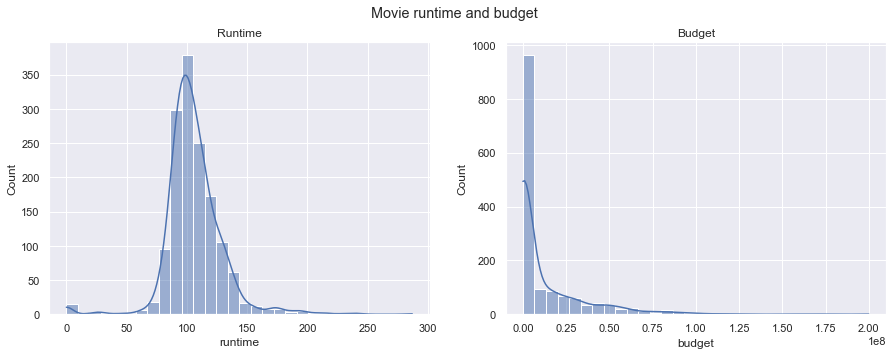

In [412]:
# histogram of runtimes, budget 
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Movie runtime and budget')
sns.histplot(ax=axes[0], x=dfFeatures['runtime'], bins=30, kde=True)
axes[0].set_title('Runtime')
sns.histplot(ax=axes[1], x=dfFeatures['budget'], bins=30, kde=True)
axes[1].set_title('Budget')
fig.show()


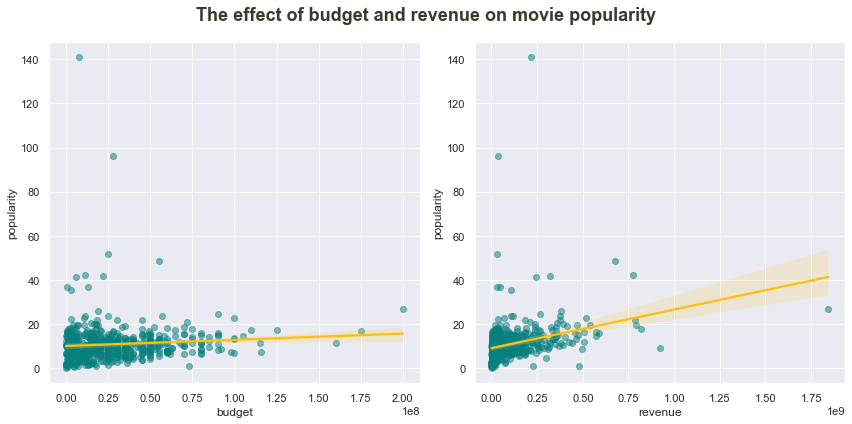

In [413]:
#  set sns figure size
sns.set(rc={'figure.figsize':(12, 6)})
#  set sns color palette
sns.set_palette(sns.color_palette("Set3"))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.suptitle('The effect of budget and revenue on movie popularity', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=dfFeatures[(dfFeatures.budget != 0) & dfFeatures.revenue != 0 ], x=col, y='popularity',
                scatter_kws={"color": "#06807e", "alpha": 0.5}, line_kws={"color": "#fdc00e"}, ax=axes[i])

plt.tight_layout()

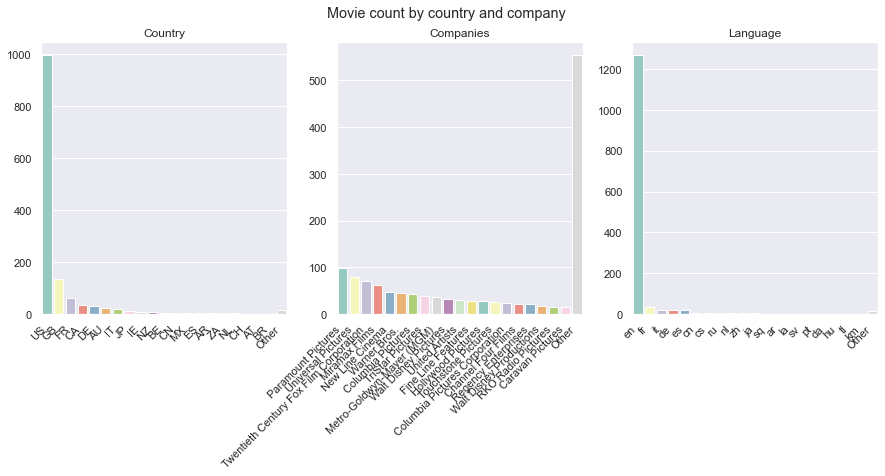

In [414]:
def getEntity(x, type='iso_3166_1'):
    try:
        return eval(str(x))[0][type]
    except:
        return None
dfFeatures['productionCountry'] = dfFeatures.production_countries.apply(lambda x: getEntity(x, 'iso_3166_1'))
dfFeatures['productionCompany'] = dfFeatures.production_companies.apply(lambda x: getEntity(x, 'name'))
dfFeatures['language'] = dfFeatures.spoken_languages.apply(lambda x: getEntity(x, 'iso_639_1'))
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Movie count by country and company')
# set figure color palette
sns.set_palette(sns.color_palette("Set3"))
keepTop= 20
GB= dfFeatures['productionCountry'].value_counts()
GBIdx= GB.index[:keepTop].append(pd.Index(['Other']))
GBValues= GB.values[:keepTop].tolist()
GBValues.append(GB.values[keepTop:].sum())
sns.barplot(ax=axes[0], x=GBIdx, y=GBValues, palette='Set3')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[0].set_title('Country')

GB= dfFeatures['productionCompany'].value_counts()
GBIdx= GB.index[:keepTop].append(pd.Index(['Other']))
GBValues= GB.values[:keepTop].tolist()
GBValues.append(GB.values[keepTop:].sum())
sns.barplot(ax=axes[1], x=GBIdx, y=GBValues, palette='Set3')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_title('Companies')

GB= dfFeatures['language'].value_counts()
GBIdx= GB.index[:keepTop].append(pd.Index(['Other']))
GBValues= GB.values[:keepTop].tolist()
GBValues.append(GB.values[keepTop:].sum())
sns.barplot(ax=axes[2], x=GBIdx, y=GBValues, palette='Set3')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[2].set_title('Language')
fig.show()

### Age of movie
We have the release date from which we can calculate the age of the movie as per the 1998 (the "youngest movie of in this dataset).

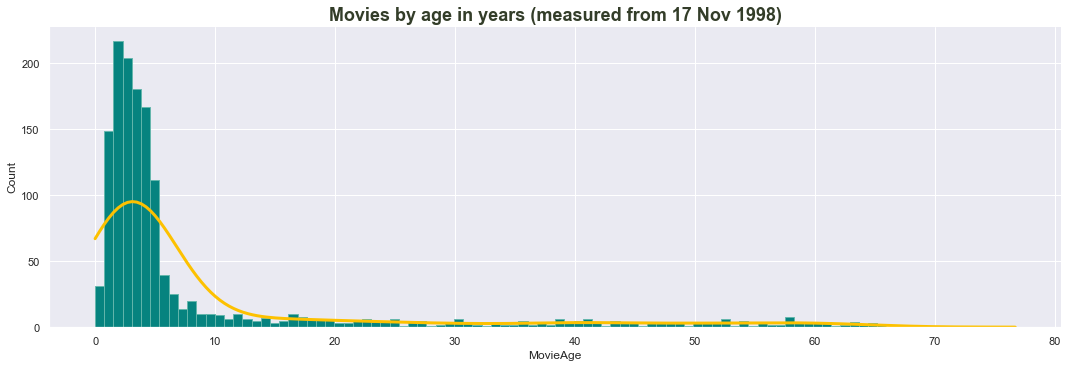

In [415]:
maxDate= dfFeatures['release_date'].max()
dfFeatures['MovieAge']= (maxDate - dfFeatures['release_date']).dt.days/365
sns.displot(data=dfFeatures, x='MovieAge', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3, bins=100)
plt.title(f'Movies by age in years (measured from {maxDate.strftime("%d %b %Y")})', fontsize=18, weight=600, color='#333d29')
plt.show()

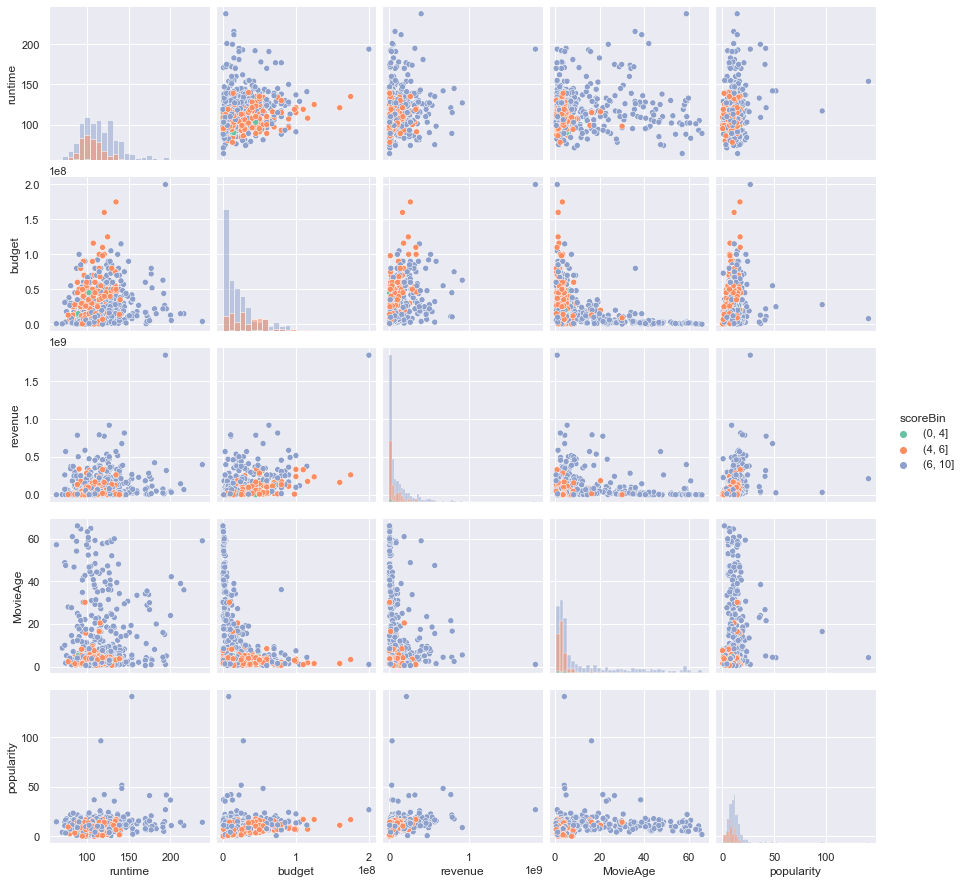

In [416]:
# df_moviesHeader.info()
# get the effect of the runtime, budget on the score
sns.set(rc={'figure.figsize':(15, 15)})
dfFeatures.runtime= dfFeatures.runtime.fillna(0)
dfFeatures['scoreBin']= pd.cut(dfFeatures['vote_average'], bins=[0,4,6,10])
dfPP= dfFeatures[(dfFeatures.budget != 0) & (dfFeatures.revenue != 0)  & (dfFeatures.runtime > 0) & (dfFeatures['vote_average'] > 0)]
sns.pairplot(dfPP[['scoreBin','runtime','budget', 'revenue', 'MovieAge', 'popularity']], hue='scoreBin', diag_kind='hist', palette='Set2')
plt.show()

In [427]:
#  drop columns 'production_companies', 'production_countries', 'release_date_x', 'release_date', 'ReleaseYear', 'original_title', 'scoreBin'
dfFeatures.drop(columns=['production_companies', 'production_countries', 'release_date_x', 'release_date', 'ReleaseYear', 'scoreBin', 'id','spoken_languages'], inplace=True, errors='ignore')
#  keep movies with original_title not null, so they have all enrichments
dfFeatures= dfFeatures[dfFeatures.original_title.notnull()]
# print(dfFeatures.columns)
dfFeatures.head(3)

,movie id,adult,budget,original_language,original_title,overview,popularity,revenue,runtime,tagline,...,Mystery,Romance,Sci_Fi,Thriller,War,Western,MovieAge,productionCountry,productionCompany,language
0,1,True,30000000.0,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,373554033.0,81.0,In 1930's Shanghai violence was not the proble...,...,0,0,0,0,0,0,3.052055,US,Pixar Animation Studios,en
1,2,True,58000000.0,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,352194034.0,130.0,No limits. No fears. No substitutes.,...,0,0,0,1,0,0,3.005479,GB,United Artists,en
2,3,True,4000000.0,en,Four Rooms,It's Ted the Bellhop's first night on the job....,9.026586,4300000.0,98.0,Twelve outrageous guests. Four scandalous requ...,...,0,0,0,1,0,0,2.942466,US,Miramax Films,en


<br><br><br><br><br><br>
# Question 2:
# Item Similarity

The following blog posts [link1](https://medium.com/@bindhubalu/content-based-recommender-system-4db1b3de03e7), [link2](https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e), will be helpful for answering questions 2 and 3. 

Please provide code and explanations for your answer.  
In case you don't have a clear answer, please provide your best hypothesis.

### Build a movie profile vector based on the item features of your choice. 
Select at least two features from the dataset. Describe the potential contribution of each feature to a content based model.
Tip: When looking on the MovieLens dataset its features vector will include `genres`, `title`, etc.

#### Feature 1- Age of movie
Some user might find older movies to be irrelevant while others would not mind seeing older movies.

#### Feature 2- Localle- Production country & language
Some users would not mind seeing movies from other countries but most have a tase for a specific localle, like american movies in english.

#### Feature 3- Budget and Revenue
Some users might be attracted only to bug budget movies (big studios, famous actors) while others might be OK with cheaper movies such as 

#### Feature 4- Popularity
Popularity can be a good feature as some users might have a taste for the common, which is popular. 

In [420]:
colsToKeep= ['productionCountry', 'MovieAge','movie id', 'budget', 'original_language', 'popularity', 'revenue', 'runtime',
       'vote_average', 'unknown', 'Action','Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery',
       'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']
dfFeatures2= dfFeatures[colsToKeep].copy()
dfFeatures2['productionCountry']= dfFeatures2['productionCountry'].apply(lambda x: 1 if x == 'US' else 0)
dfFeatures2['original_language']= dfFeatures2['original_language'].apply(lambda x: 1 if x == 'en' else 0)
dfFeatures2.set_index('movie id', inplace=True)
dfFeatures2.sort_index(axis=0, inplace=True)
item_features= dfFeatures2.copy()
# normalize the data between 0 and 1
item_features= (item_features - item_features.min()) / (item_features.max() - item_features.min())
item_features.head(4)

,productionCountry,MovieAge,budget,original_language,popularity,revenue,runtime,vote_average,unknown,Action,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.039777,0.15000,1.0,0.155707,0.202465,0.282230,0.77,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.039170,0.29000,1.0,0.104193,0.190888,0.452962,0.66,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.038349,0.02000,1.0,0.064041,0.002331,0.341463,0.65,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.040134,0.15125,1.0,0.089887,0.062385,0.365854,0.64,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Build a function which provides the 5 most similar items to an input item (item_id). 
Please use `Cosine Similarity` metric to calculate Item to item similarity.  
Notice: while it is a great way to debug your code, make sure not to return the actual input `item_id` in your results.


In [422]:
def get_cosine_similarity(a, b):
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)


In [439]:

def get_similar_items(item_features, item_id, n=5):
    ''' 
    item_id : target item 
    n : number of similar items to return
    This function returns a dataframe\array with ids of n most similar items to the target item and the similarity score
    '''
    itemVector= item_features.loc[item_id].values
    if isinstance(item_features, pd.DataFrame):
        item_features_arr = item_features.values
    #  loop on all items and calculate the similarity score
    similarity_scores = []
    for i in range(item_features.shape[0]):
        similarity_scores.append(get_cosine_similarity(item_features_arr[i], itemVector))
    #  get the n most similar items
    most_similar_items = np.argsort(similarity_scores)[::-1][1:n+1]
    #  return the ids of the n most similar items and the similarity score
    return item_features.iloc[most_similar_items], similarity_scores[1:n+1]

### Use the above function to find the 5 most similar items for any 2 items from the dataset. 
Please discuss the results you got. Are there any issues with the quality of the results? 

Please add the movie's title and image to your explanation.

In [461]:
from IPython.display import HTML, Image

def _src_from_data(data):
    """Base64 encodes image bytes for inclusion in an HTML img element"""
    img_obj = Image(data=data)
    for bundle in img_obj._repr_mimebundle_():
        for mimetype, b64value in bundle.items():
            if mimetype.startswith('image/'):
                return f'data:{mimetype};base64,{b64value}'

def gallery(images, row_height='auto'):
    """Shows a set of images in a gallery that flexes with the width of the notebook.
    
    Parameters
    ----------
    images: list of str or bytes
        URLs or bytes of images to display

    row_height: str
        CSS height value to assign to all images. Set to 'auto' by default to show images
        with their native dimensions. Set to a value like '250px' to make all rows
        in the gallery equal height.
    """
    figures = []
    for image in images:
        if isinstance(image, bytes):
            src = _src_from_data(image)
            caption = ''
        else:
            src = image
            # caption = f'<figcaption style="font-size: 0.6em">{image}</figcaption>'
            caption = ''
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="{src}" style="height: {row_height}">
              {caption}
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


#### Getting recommendations based on the Movie "Terminator 2: Judgment Day"
<img src="https://m.media-amazon.com/images/M/MV5BMGU2NzRmZjUtOGUxYS00ZjdjLWEwZWItY2NlM2JhNjkxNTFmXkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_.jpg" width=120/>

In [465]:
# first
itemID=96
items, scores= get_similar_items(item_features, itemID, n=5)
print(f'item requested is {df_items.iloc[itemID-1]["movie_title"]}')
print(f'the titles of the movies returned are {df_items.loc[items.index-1]["movie_title"].values}')
urls= ["https://m.media-amazon.com/images/M/MV5BMGI3OTg1NzItNDQxMS00MzY1LTkzODUtYjNkMmUzNTE0MWE0XkEyXkFqcGdeQXVyNDAxNjkxNjQ@._V1_.jpg"\
        , "https://m.media-amazon.com/images/M/MV5BNTdhYjEzYTEtYTkwZC00NzgxLWI0ZWEtYmEyMGZhOWYwMjE2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_.jpg"\
            , "https://m.media-amazon.com/images/M/MV5BYTViNzMxZjEtZGEwNy00MDNiLWIzNGQtZDY2MjQ1OWViZjFmXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_FMjpg_UX1000_.jpg"
            ,"https://m.media-amazon.com/images/M/MV5BYWZhODdkMTEtMzBmNy00NzU5LWIzYjMtYTkwNWE3YTRjOTZkXkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_.jpg"
            ,"https://m.media-amazon.com/images/M/MV5BYzFjNzIxMmEtMzY5NS00YTgzLTkwYWEtN2FjMmY0NmNkZWY3XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_.jpg"]
gallery(urls, row_height='150px')

item requested is Terminator 2: Judgment Day (1991)
the titles of the movies returned are ['Arrival, The (1996)' 'Johnny Mnemonic (1995)' 'Terminator, The (1984)'
 'Lawnmower Man, The (1992)' 'Face/Off (1997)']


#### Getting recommendations based on the Movie "Toy story"
<img src="https://m.media-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_.jpg" width=120/>

In [471]:
itemID=1
items, scores= get_similar_items(item_features, itemID, n=5)
print(f'item requested is {df_items.iloc[itemID-1]["movie_title"]}')
print(f'the titles of the movies returned are {df_items.loc[items.index-1]["movie_title"].values}')
urls= ["https://m.media-amazon.com/images/M/MV5BODFkMjE5YzAtMDFkOC00ZDNhLTkwNmQtODk1Y2VhNThlNWJhXkEyXkFqcGdeQXVyNzY1NDgwNjQ@._V1_.jpg"\
        , "https://lumiere-a.akamaihd.net/v1/images/p_aladdin1992_20486_174ba005.jpeg"\
            , "https://m.media-amazon.com/images/M/MV5BZDczYjU4MDMtY2RjMy00Y2UyLWE2MmMtZjliYWUwNzQ3YjExXkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_.jpg"
            ,"https://m.media-amazon.com/images/M/MV5BYzI0ZGRiYTEtNGExYi00ZDI2LWExMjMtODMzNDZjMTVjOWMxXkEyXkFqcGdeQXVyNTIzOTk5ODM@._V1_.jpg"
            ,"https://m.media-amazon.com/images/M/MV5BMzFkM2YwOTQtYzk2Mi00N2VlLWE3NTItN2YwNDg1YmY0ZDNmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_.jpg"]
gallery(urls, row_height='150px')


item requested is Toy Story (1995)
the titles of the movies returned are ['Aladdin and the King of Thieves (1996)' 'Aladdin (1992)'
 'Goofy Movie, A (1995)' 'Santa Clause, The (1994)' 'Home Alone (1990)']


<br>
# Question 3:
# Content based recommendation



### Build a function which recommends n=5 most relevant items to a user. 

In [473]:
# only keep ratings for movies in the features dataset
dfRatings= ratings[item_features.index]
dfRatings.sort_index(axis=0, inplace=True)
dfRatings.head(2)

#  build the user features matrix
user_features= pd.DataFrame(columns=item_features.columns)
for user in tqdm(dfRatings.index):
    user_features.loc[user]= (item_features.mul(dfRatings.loc[user], axis=0)).mean(axis=0)
print(user_features.shape)
user_features.head(2)

100%|██████████| 943/943 [00:01<00:00, 726.82it/s]

(943, 27)


,productionCountry,MovieAge,budget,original_language,popularity,revenue,runtime,vote_average,unknown,Action,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
1,0.439074,0.077367,0.052377,0.556841,0.053697,0.036392,0.238606,0.417740,0.002723,0.154527,...,0.004765,0.003404,0.027910,0.025868,0.012253,0.106875,0.108237,0.116406,0.057182,0.011572
2,0.104833,0.008330,0.021576,0.138189,0.011253,0.012801,0.060837,0.097842,0.000000,0.025868,...,0.002042,0.006127,0.004084,0.002042,0.009530,0.039483,0.010211,0.025868,0.007488,0.000000


In [474]:
def get_item_recommendations(item_features, user_features, user_id, n=5):
    ''' 
    user_id: id of target user
    n : number of recommended items
    
    This function returns a dataframe\array with ids of n recommended items and their scores
    '''
    userVector= user_features.loc[user_id].values
    item_features_arr = item_features.values
    #  loop on all items and calculate the similarity score
    similarity_scores = []
    for i in range(item_features.shape[0]):
        similarity_scores.append(get_cosine_similarity(item_features_arr[i], userVector))
    #  get the n most similar items
    most_similar_items = np.argsort(similarity_scores)[::-1][1:n+1]
    #  return the ids of the n most similar items and the similarity score
    return item_features.iloc[most_similar_items], similarity_scores[1:n+1]    

### Test your recommender system on 2 users. Explain your results.

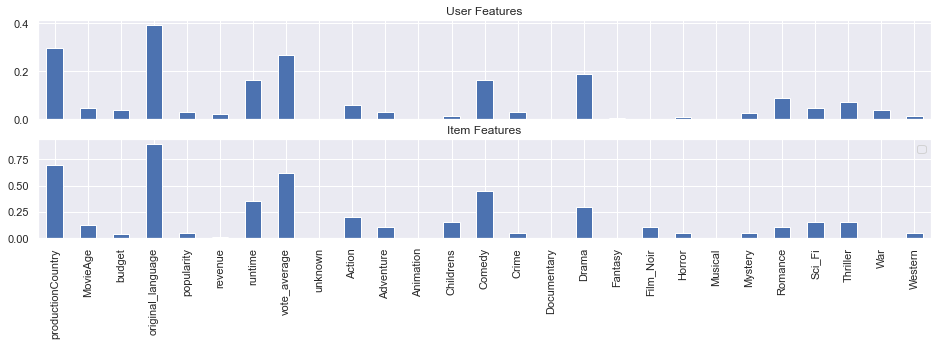

In [502]:
user_id = 11  
items, score = get_item_recommendations(item_features, user_features, user_id, n=20)  
fig, axes = plt.subplots(ncols=1, nrows=2,figsize=(16,4), sharex=True)  
user_features.loc[user_id].plot(kind='bar',ax=axes[0]);  
item_features.iloc[items.index].mean().T.plot(kind='bar',ax=axes[1]); 
axes[0].set_title('User Features');
axes[1].set_title('Item Features');
plt.legend(df_items.loc[df_items.index.isin(items)].movie_title);


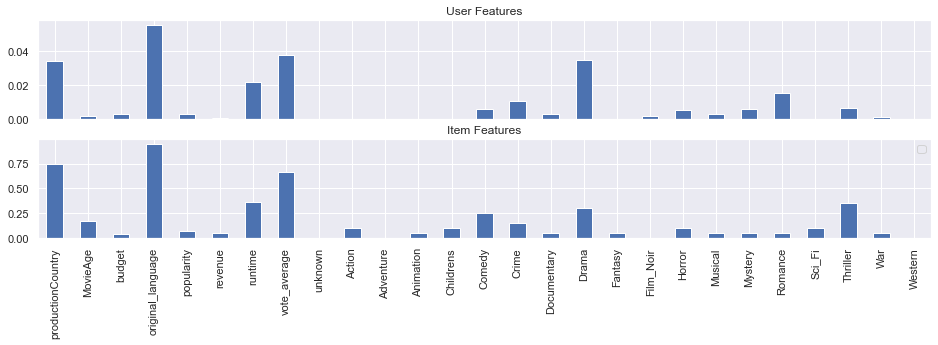

In [501]:
user_id = 50  
items, score = get_item_recommendations(item_features, user_features, user_id, n=20)  
fig, axes = plt.subplots(ncols=1, nrows=2,figsize=(16,4), sharex=True)  
user_features.loc[user_id].plot(kind='bar',ax=axes[0]);  
item_features.iloc[items.index].mean().T.plot(kind='bar',ax=axes[1]); 
axes[0].set_title('User Features');
axes[1].set_title('Item Features');
plt.legend(df_items.loc[df_items.index.isin(items)].movie_title);

### Use the MRR metric to evaluate your recommender system on the test set. 
Use a cutoff value of 5.

<br><br><br><br><br>
# Question 4
# Content based recommendations vs. Matrix Factorization

### Use MF's  item representation to find the most similar items
Use the matrix factorization item representation you built in exercise 1 to find the most similar items for **the same 2 items** you used above. 
(Use your optimal hyperparams and resulting model)

Compare the results you got using the different methods below and discuss your findings

In [ ]:
# we recommend creating - class MF

In [ ]:
# find similar items to the same two items you chose
pass

### Use MF implementation for item recommendations 

Use the matrix factorization implemention from exercise 1 to recommend 5 items to **the same 2 users** you used above. 
(Use your optimal hyperparams and resulting model)

Compare the results you got using the different methods. Discuss your findings

### Compare the results of the content based recommender system to the matrix factorization recommender system

- Please use the same train and test set. 
- Please use the MRR metric for the comparison (provide a comparison plot). 

### Advantages & Disadvantages 

Please use the following table to discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems.
Please address the following aspects in your discussion, and feel free to add your own.

<table>
    <thead>
        <tr>
            <th>..</th>
            <th style="text-align:center">Content-Based</th>
            <th style="text-align:center">Matrix-Factorization</th>
            <th style="text-align:left">Notes:</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Dimensionality</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Similarity</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Tranining Complexity</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Inference Complexity</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Explanability</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Scalability</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>        
        <tr>
            <td>New User</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>New Item</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Train Time</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Predict Time</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Deterministic</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
    </tbody>
</table>

<br>

Good Luck :)